In [51]:
import warnings
warnings.filterwarnings("ignore")
from run import main
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.lines import Line2D

In [52]:
# set up dataframe for collecting event data
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    mtd_type: 'shuffle_diversity', 'shuffle', diversity
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
"""
SIM_TIME = 2000
time_network, adversary = main(finish_time=SIM_TIME, mtd_type='shuffle_diversity')

Adversary: Start SCAN_HOST at 0.0s.
MTD: IPShuffle triggered 0.0s
MTD: IPShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: HostTopologyShuffle triggered 30.3s
MTD: HostTopologyShuffle suspended at 30.3s due to resource occupation
Adversary: Processed SCAN_PORT at 45.0s.
Adversary: Start EXPLOIT_VULN at 45.0s.
MTD: IPShuffle finished in 50.1s at 50.1s.
MTD: Interrupted EXPLOIT_VULN at 50.1s!
Adversary: Restarting with SCAN_HOST at 52.1s!
Adversary: Start SCAN_HOST at 52.1s.
MTD: HostTopologyShuffle triggered 60.8s
MTD: HostTopologyShuffle deployed in the network at 60.8s.
Adversary: Processed SCAN_HOST at 62.1s.
Adversary: Start ENUM_HOST at 62.1s.
Adversary: Processed ENUM_HOST at 77.1s.
Adversary: Start SCAN_PORT at 77.1s.
MTD: IPShuffle triggered 91.6s
MTD: IPShuffle suspended at 91.6s due to resource occupation
Adversary: Processed S

In [53]:
mtd_operation_record = pd.DataFrame(time_network.get_mtd_stats().get_record())
attack_operation_record = pd.DataFrame(adversary.get_attack_stats().get_record())
current_directory = os.getcwd()
if not os.path.exists(current_directory+'\\data_analysis'):
    os.makedirs(current_directory+'\\data_analysis')

attack_operation_record.to_csv('data_analysis/attack_operation_record_'+str(SIM_TIME)+'.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record_'+str(SIM_TIME)+'.csv', index=False)

In [54]:
# print(time_network.get_mtd_stats().dict())
mtd_operation_record.head()

,name,start_time,finish_time,duration,executed_at
0,IPShuffle,0.000000,50.052736,50.052736,network
1,HostTopologyShuffle,60.849897,121.738244,60.888347,network
2,IPShuffle,151.801172,202.234811,50.433639,network
3,osdiversity,182.402870,212.453458,30.050588,application
4,PortShuffle,213.366628,249.423768,36.057139,application


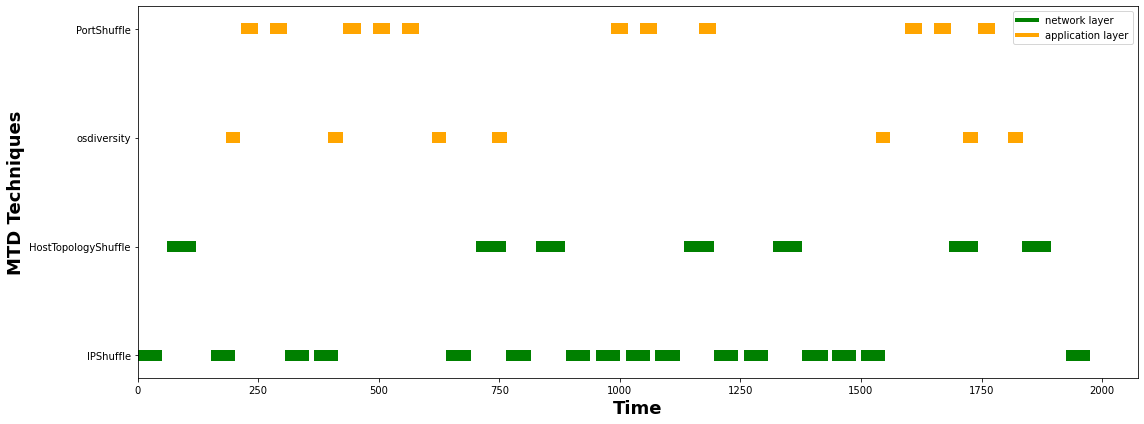

In [55]:
mtd_operation_record['color'] = np.where(mtd_operation_record['executed_at']=='network', 'green', 'orange')
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1, color=mtd_operation_record['color'])


custom_lines_mtd = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4)]
ax.legend(custom_lines_mtd, ['network layer', 'application layer'], loc='upper right')
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.savefig('data_analysis/mtd_record.png')
plt.show()

In [56]:
attack_operation_record.head()

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,10.000000,10.000000,-1,0,0,0,None,[],None,None
1,ENUM_HOST,10.000000,25.000000,15.000000,-1,0,0,0,None,[],None,None
2,SCAN_PORT,25.000000,45.000000,20.000000,0,1,0,0,None,[],None,None
3,EXPLOIT_VULN,45.000000,50.052736,5.052736,0,1,0,0,None,[],network,IPShuffle
4,SCAN_HOST,52.052736,62.052736,10.000000,-1,0,0,0,None,[],None,None


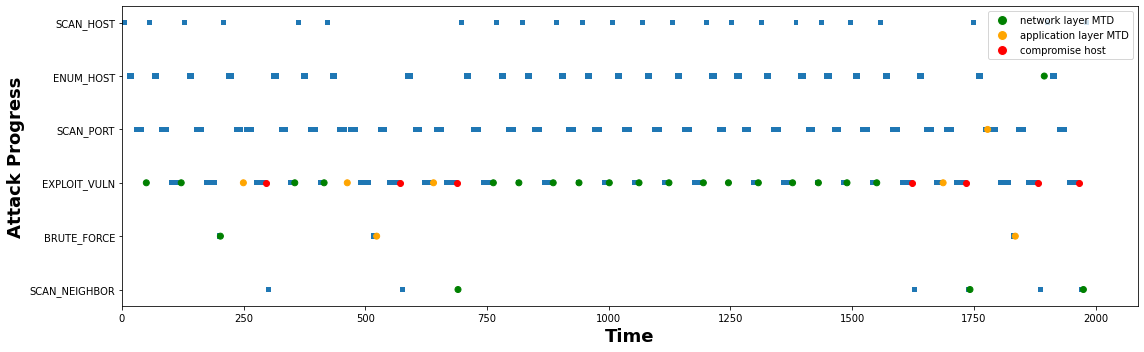

In [57]:
fig2, ax2 = plt.subplots(1, figsize=(16, 5))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1, zorder=1)


interrupted_record = attack_operation_record[attack_operation_record['interrupted_in']!='None']
interrupted_record['color'] = np.where(interrupted_record['interrupted_in']=='network', 'green', 'orange')
ax2.scatter(interrupted_record['finish_time'], interrupted_record['name'], color=interrupted_record['color'], zorder=3)


compromise_record = attack_operation_record[attack_operation_record['compromise_host'] != 'None']
ax2.scatter(compromise_record['finish_time'], compromise_record['name'], color='red', zorder=2)


custom_lines_attack = [Line2D([0], [0], marker='o',color='w', markerfacecolor='green', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='orange', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='red', markersize=10),]

ax2.legend(custom_lines_attack, ['network layer MTD', 'application layer MTD', 'compromise host'], loc='upper right')

plt.gca().invert_yaxis()
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.savefig('data_analysis/attack_record.png')
plt.show()

In [58]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by


In [59]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
18,EXPLOIT_VULN,271.423768,296.596595,25.172827,0,4,21,0,0,"[Ronnie, Ranna, Barbabra, Fionna, Gwenore]",None,None
35,EXPLOIT_VULN,545.206143,571.937020,26.730878,32,3,50,1,32,"[Lissy, Amabelle, Toby, Ruperta]",None,None
41,EXPLOIT_VULN,662.009595,687.644671,25.635076,34,1,59,2,34,"[Arlinda, Marji, Sindee, Vivianne]",None,None
102,EXPLOIT_VULN,1597.423180,1623.226875,25.803695,51,2,63,3,51,"[Adrienne, Benny, Zonda, Beverley, Kirsteni]",None,None
108,EXPLOIT_VULN,1708.782900,1733.795251,25.012351,23,4,74,4,23,"[Jessi, Nixie, Cary, Rica]",None,None
117,EXPLOIT_VULN,1857.054753,1882.535018,25.480265,32,10,104,5,32,"[Cheryl, Lyndy, Mufinella, Xylia]",None,None
123,EXPLOIT_VULN,1941.510813,1966.529756,25.018944,22,3,125,6,22,"[Toma, Sula, Gavra, Brynna]",None,None


In [60]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
